# Welcome to the notebook for Data Science Job Postings in Hong Kong

Since we are here, we could agree that data science is a cool profession.

When "Data Science is the sexist job of the 21 century" by Harvard Business Review  took a storm on the internet on 2012, Hong Kong was still starting out on the big data trend. So, 10 years has past, what is the status quo of the data industry? To gain insights to answer this question, I have scrapped job postings from one of popular job posting platform in Hong Kong and perform some data analysis. 

# Findings

* As of 6 December 2022, number of job postings under category Data Science on Jobsdb HK platform is 349
* Among generic roles in the data industry, data analyst is the most in demand role (84 job advertisements), followed by data engineer(35) and data scientist(18)
* Only 22 out of 348 (<10%) of job postings provided salary information. The salary range is 14000 - 90000 HKD
* Most workplaces are located in Shatin, Central & Western area and Kowloon Bay. 
* All job postings requires at least 1 year of experience (yoe)
* The salary distribution of job postings that requires 1 yoe is statiscally the same as the salary distribution of job postings the requires 2 yoe
* Most of the job postings requires degree level qualification (85%)
* Most of the job postings are middle level ( 137 of 238), followed by entry level(70). Senior positions are less(31). 
* Salary offer seems to be largely influenced by company (note that lack of salary data to run statistical test)

# Discussion
* Data analyst dominates data job market and few data scientist position: Hong Kong is taking time to transition to data driven business. 
* Salary transperency is far from satisfaction. This makes us harder to measure potential gender wage gaps. We can consult other platforms like glassdoors and Payscale. The limitation is those job offers are employees reported. In payscale, the public data is already in a dashboard format presenting the findings, making it virtually impossible to retrieve individual records to train machine learning algorithm to predict salary. 
* All of the entry level job postings require at least 1 yoe, implying 1 yoe is the baseline.

# the Dataset 

A python script was written ([here](https://github.com/aster-fung/hk_job_scraping)) to scrape job postings under "Information Technology\Data Scientist" category. The script was implemented in a way that for each job posting was read, an observation ( row of data) is added to the csv file. Preliminary data cleaning was incoporated to the script to make the dataset easier for downstream processing. 

The columns are 


| column | null placeholder | non-null example |
|---|---|---|
| title | (not applicable) | Data Analyst - Top ranked Virtual Bank |
| salary | "salary" | HK$35,000 - HK$55,000 /month |
| company | "company" | CGP |
| posted | (not applicable) | 2022-11-18 |
| District | "district" | Shatin district |
| job description | (not applicable) | Job Description:  Research, collate, obtain and analyze data ... |
| Career level | empty | Entry Level |
| Years of Experience | empty | N/A |
| Company Website | empty | www.companyname.com |
| Qualification | empty | Degree |
| Job Type | empty | Full Time, Permanent |
| Job Functions | empty | Banking / Finance, Others, Information Technology (IT), Others, Data Scientist |
| url | empty | https://hk.jobsdb.com/hk/en/job/data-analyst-data-governance-... |

# the Analysis

## import module and data

In [1]:
# scrap the data

# run hkjobsdb_scrap.py outside of this notebook
# returns <job title-date of scrap-number>.csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from geopy.geocoders import Nominatim
from geopandas import gpd
import folium
from scipy.stats import f_oneway
sns.set_theme()

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
# important parameters
file_name = ('data-scientist-2022-12-06-1.csv')

In [4]:
# # uncomment this block to run locally
# df_raw = pd.read_csv(file_name)

In [5]:
# uncomment this block to run on kaggle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)


df_raw = pd.read_csv("/kaggle/input/ds-obsdbhk/data-scientist-2022-12-06-1.csv")

## Data inspection 

In [6]:
df_raw.head(5)

,title,salary,company,posted,district,job_description,Career Level,Years of Experience,Company Website,Qualification,Job Type,Job Functions,url
0,Data Scientist,salary,Connexe Search Limited,2022-12-06,Kowloon Bay,Our client is one of the leading financial ins...,NaN,NaN,NaN,NaN,Contract,"Banking / Finance, Others, Information Technol...",https://hk.jobsdb.com/hk/en/job/data-scientist...
1,Data Analyst (Data & AI),salary,NCSI (HK) Limited,2022-12-06,Tai Koo,Key Role Responsibilities:\n\nParticipate in c...,NaN,NaN,http://www.ncs-i.com,NaN,"Full Time, Permanent","Information Technology (IT), Product Managemen...",https://hk.jobsdb.com/hk/en/job/data-analyst-d...
2,Data Analyst (Data Governance),salary,Gientech Technology (Hong Kong) Limited,2022-12-06,Ngau Tau Kok,Duties:\nManage & support data governance mode...,Middle,3 years,NaN,Degree,"Full Time, Permanent","Information Technology (IT), Data Scientist",https://hk.jobsdb.com/hk/en/job/data-analyst-d...
3,Solution Analyst - ICC - Data Integration,salary,Cathay Pacific Airways Ltd,2022-12-06,Lantau Island,Reports to: Solution Lead / Senior Solution Le...,NaN,NaN,http://www.cathaypacific.com/careers,NaN,"Full Time, Permanent","Transportation & Logistics, Aviation Services,...",https://hk.jobsdb.com/hk/en/job/solution-analy...
4,Analyst Programmer (Data Analytics),salary,China State Construction Engineering (Hong Kon...,2022-12-06,district,Job Description:\nEstablish and maintain high-...,Entry Level,3 years,https://www.cscechk.com/en/,Degree,"Full Time, Permanent","Information Technology (IT), DBA, Others, Data...",https://hk.jobsdb.com/hk/en/job/analyst-progra...


In [7]:
# function to replace custom missing value placeholder to NaN values
def replace_with_nan(col, target_to_be_replaced):
    try:
        col.replace(target_to_be_replaced, np.nan, inplace=True)
    except:
        print('replacement with nan failed')

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                349 non-null    object
 1   salary               349 non-null    object
 2   company              349 non-null    object
 3   posted               349 non-null    object
 4   district             345 non-null    object
 5   job_description      349 non-null    object
 6   Career Level         264 non-null    object
 7   Years of Experience  233 non-null    object
 8   Company Website      214 non-null    object
 9   Qualification        281 non-null    object
 10  Job Type             349 non-null    object
 11  Job Functions        349 non-null    object
 12  url                  349 non-null    object
dtypes: object(13)
memory usage: 35.6+ KB


In [9]:
df_raw.describe()

,title,salary,company,posted,district,job_description,Career Level,Years of Experience,Company Website,Qualification,Job Type,Job Functions,url
count,349,349,349,349,345,349,264,233,214,281,349,349,349
unique,255,15,178,29,39,290,3,12,96,5,11,124,316
top,Data Analyst,salary,Manpower Services (Hong Kong) Limited,2022-12-02,district,Our client is a multinational bank with an all...,Middle,3 years,http://www.manpowergroupgrc.hk,Degree,"Full Time, Permanent","Information Technology (IT), Data Scientist",https://hk.jobsdb.com/hk/en/job/data-analyst-f...
freq,17,323,19,30,88,5,153,82,20,240,205,43,2


* missing values in district, career level, years of experience, company website and qualitification 
* some of the missing info in qualification is found in job_description
* there might be duplicate jobs ads

* next: remove duplicates (data cleaning) and inspect each column

## Data Cleaning

In [10]:
df_clean_1 = df_raw.copy()

In [11]:
# drop duplicates
df_clean_1.drop_duplicates(inplace=True)
df_clean_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316 entries, 0 to 348
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                316 non-null    object
 1   salary               316 non-null    object
 2   company              316 non-null    object
 3   posted               316 non-null    object
 4   district             312 non-null    object
 5   job_description      316 non-null    object
 6   Career Level         238 non-null    object
 7   Years of Experience  208 non-null    object
 8   Company Website      194 non-null    object
 9   Qualification        254 non-null    object
 10  Job Type             316 non-null    object
 11  Job Functions        316 non-null    object
 12  url                  316 non-null    object
dtypes: object(13)
memory usage: 34.6+ KB


In [12]:
# convert all strings to lowercase 
# df_clean_1['title']= df_clean_1["title"].str.lower()

In [13]:
df_clean_1[df_clean_1["title"].str.contains("analyst",case=False)].head()

,title,salary,company,posted,district,job_description,Career Level,Years of Experience,Company Website,Qualification,Job Type,Job Functions,url
1,Data Analyst (Data & AI),salary,NCSI (HK) Limited,2022-12-06,Tai Koo,Key Role Responsibilities:\n\nParticipate in c...,NaN,NaN,http://www.ncs-i.com,NaN,"Full Time, Permanent","Information Technology (IT), Product Managemen...",https://hk.jobsdb.com/hk/en/job/data-analyst-d...
2,Data Analyst (Data Governance),salary,Gientech Technology (Hong Kong) Limited,2022-12-06,Ngau Tau Kok,Duties:\nManage & support data governance mode...,Middle,3 years,NaN,Degree,"Full Time, Permanent","Information Technology (IT), Data Scientist",https://hk.jobsdb.com/hk/en/job/data-analyst-d...
3,Solution Analyst - ICC - Data Integration,salary,Cathay Pacific Airways Ltd,2022-12-06,Lantau Island,Reports to: Solution Lead / Senior Solution Le...,NaN,NaN,http://www.cathaypacific.com/careers,NaN,"Full Time, Permanent","Transportation & Logistics, Aviation Services,...",https://hk.jobsdb.com/hk/en/job/solution-analy...
4,Analyst Programmer (Data Analytics),salary,China State Construction Engineering (Hong Kon...,2022-12-06,district,Job Description:\nEstablish and maintain high-...,Entry Level,3 years,https://www.cscechk.com/en/,Degree,"Full Time, Permanent","Information Technology (IT), DBA, Others, Data...",https://hk.jobsdb.com/hk/en/job/analyst-progra...
5,Business Intelligence Analyst,salary,Bureau Veritas Hong Kong Limited,2022-12-06,Kowloon Bay,Responsibilities:\nBuild dashboards to suppor...,Middle,5 years,NaN,Degree,"Full Time, Permanent","Professional Services, Business Analysis / Dat...",https://hk.jobsdb.com/hk/en/job/business-intel...


In [14]:
len(df_clean_1[df_clean_1["title"].str.contains("analyst",case=False)])

135

In [15]:
df_clean_1.columns = df_clean_1.columns.str.lower()
df_clean_1.columns

Index(['title', 'salary', 'company', 'posted', 'district', 'job_description',
       'career level', 'years of experience', 'company website',
       'qualification', 'job type', 'job functions', 'url'],
      dtype='object')

In [16]:
# rearrange the columns for easier reading
df_clean_1 = df_clean_1[['title',
                          'salary',
                          'company',
                          'posted',
                          'district',
                          'career level',
                          'years of experience',
                          'qualification',
                          'job type',
                          'job functions',
                          'job_description',
                          'url']
                        ]

In [17]:
df_clean_1.columns

Index(['title', 'salary', 'company', 'posted', 'district', 'career level',
       'years of experience', 'qualification', 'job type', 'job functions',
       'job_description', 'url'],
      dtype='object')

In [18]:
# inspect career level
df_clean_1['career level'].unique()

array([nan, 'Middle', 'Entry Level', 'Senior'], dtype=object)

In [19]:
df_clean_1['career level'].value_counts()

Middle         137
Entry Level     70
Senior          31
Name: career level, dtype: int64

In [20]:
# inspect salary
df_clean_1['salary'].unique()
# very few ads are transparent with salary

array(['salary', 'HK$30,000 - HK$45,000 /month',
       'HK$70,000 - HK$90,000 /month', 'HK$30,000 - HK$70,000 /month',
       'HK$25,000 - HK$70,000 /month', 'HK$30,000 - HK$55,000 /month',
       'HK$20,000 - HK$55,000 /month', 'HK$30,000 - HK$35,000 /month',
       'HK$25,000 - HK$55,000 /month', 'HK$25,000 - HK$30,000 /month',
       'HK$20,000 - HK$30,000 /month', 'HK$35,000 - HK$55,000 /month',
       'HK$25,000 - HK$35,000 /month', 'HK$14,000 - HK$20,000 /month',
       'HK$25,000 - HK$45,000 /month'], dtype=object)

In [21]:
df_clean_1['salary'].value_counts()

salary                          294
HK$30,000 - HK$45,000 /month      3
HK$30,000 - HK$55,000 /month      2
HK$25,000 - HK$55,000 /month      2
HK$25,000 - HK$30,000 /month      2
HK$20,000 - HK$30,000 /month      2
HK$35,000 - HK$55,000 /month      2
HK$25,000 - HK$35,000 /month      2
HK$70,000 - HK$90,000 /month      1
HK$30,000 - HK$70,000 /month      1
HK$25,000 - HK$70,000 /month      1
HK$20,000 - HK$55,000 /month      1
HK$30,000 - HK$35,000 /month      1
HK$14,000 - HK$20,000 /month      1
HK$25,000 - HK$45,000 /month      1
Name: salary, dtype: int64

In [22]:
# inspect district
df_clean_1['district'].unique()

array(['Kowloon Bay', 'Tai Koo', 'Ngau Tau Kok', 'Lantau Island',
       'district', 'Sheung Wan', 'Shatin Area', 'Tung Chung', 'Aberdeen',
       'Tseung Kwan O', 'Chai Wan', 'Central', 'Central & Western Area',
       nan, 'Quarry Bay', 'Wan Chai', 'Admiralty', 'Kwai Hing',
       'Overseas', 'Airport Area', 'Southern Area', 'Tsim Sha Tsui',
       'Kwun Tong', 'Tsing Yi', 'Tai Po Area', 'Others', 'North Point',
       'Hung Hom', 'Kwun Tong Area', 'Causeway Bay', 'Kwai Tsing Area',
       'Lai Chi Kok', 'Yau Tsim Mong Area', 'Cheung Sha Wan',
       'Wong Tai Sin Area', 'Sai Wan Ho', 'Tin Hau', 'Tsuen Wan Area',
       'Shau Kei Wan', 'Mong Kok'], dtype=object)

In [23]:
replace_with_nan(df_clean_1['district'], 'district')
len(df_clean_1['district'].unique())

39

In [24]:
df_clean_1['district'].value_counts()

Shatin Area               23
Central & Western Area    23
Kowloon Bay               22
Central                   19
Kwun Tong                 17
Quarry Bay                13
Wan Chai                  12
Ngau Tau Kok              10
Tai Po Area                8
Tsing Yi                   6
Aberdeen                   6
Admiralty                  5
Others                     5
Airport Area               5
Tsim Sha Tsui              5
Kwun Tong Area             4
Southern Area              4
Cheung Sha Wan             4
North Point                4
Lantau Island              3
Wong Tai Sin Area          3
Hung Hom                   3
Kwai Hing                  3
Sheung Wan                 3
Tai Koo                    3
Tseung Kwan O              2
Causeway Bay               2
Lai Chi Kok                2
Tung Chung                 1
Overseas                   1
Kwai Tsing Area            1
Yau Tsim Mong Area         1
Chai Wan                   1
Sai Wan Ho                 1
Tin Hau       

In [25]:
# inspect years of experience
df_clean_1['years of experience'].unique()

array([nan, '3 years', '5 years', '2 years', '1 year', '8 years',
       '15 years', '7 years', '4 years', '6 years', '10 years',
       '12 years', '9 years'], dtype=object)

In [26]:
df_clean_1['years of experience'].value_counts()

3 years     70
2 years     37
5 years     32
1 year      22
4 years     14
8 years     12
6 years      9
7 years      4
10 years     4
15 years     2
12 years     1
9 years      1
Name: years of experience, dtype: int64

In [27]:
# inspect qualification
df_clean_1['qualification'].unique()

array([nan, 'Degree', 'Non-Degree Tertiary', 'Postgraduate', '(N/A)',
       'Matriculated'], dtype=object)

In [28]:
# convert [N/A] to nan
replace_with_nan(df_clean_1['qualification'],'(N/A)')
df_clean_1['qualification'].unique()

array([nan, 'Degree', 'Non-Degree Tertiary', 'Postgraduate',
       'Matriculated'], dtype=object)

In [29]:
df_clean_1['qualification'].value_counts()

Degree                 217
Non-Degree Tertiary     21
Postgraduate             5
Matriculated             1
Name: qualification, dtype: int64

## Feature Extraction

In [30]:
df_clean_2  = df_clean_1.copy()

In [31]:
# extract min and max salary
df_clean_2 ["salary"]=df_clean_2 ["salary"].apply(lambda x: x.replace("HK$",""))
df_clean_2 ["salary"]=df_clean_2 ["salary"].apply(lambda x: x.replace(",",""))
df_clean_2 ["salary"]=df_clean_2 ["salary"].apply(lambda x: str(re.search('(\d+)((\s)(-)(\s)(\d+))?',x).group()) if "/" in x else x)
df_clean_2['salary'].unique()

array(['salary', '30000 - 45000', '70000 - 90000', '30000 - 70000',
       '25000 - 70000', '30000 - 55000', '20000 - 55000', '30000 - 35000',
       '25000 - 55000', '25000 - 30000', '20000 - 30000', '35000 - 55000',
       '25000 - 35000', '14000 - 20000', '25000 - 45000'], dtype=object)

In [32]:
def extract_salary_min_max(df):
    min_s_list = []
    max_s_list = []
    avg_s_list = []
    for i in df['salary']:
        if 'salary' not in i:
            min_s = int(i.split(' - ')[0])
            max_s = int(i.split(' - ')[1])
            avg_s = (min_s + max_s)//2
        else:
            min_s = 'salary'
            max_s = 'salary'
            avg_s = 'salary'
        min_s_list.append(min_s)
        max_s_list.append(max_s)
        avg_s_list.append(avg_s)
    
    return [min_s_list, max_s_list, avg_s_list]

In [33]:
df_clean_2['min_salary'] = extract_salary_min_max(df_clean_2)[0]
df_clean_2['max_salary'] = extract_salary_min_max(df_clean_2)[1]
df_clean_2['avg_salary'] = extract_salary_min_max(df_clean_2)[2]

df_clean_2.drop(['salary'], axis=1, inplace = True)
df_clean_2.head()


,title,company,posted,district,career level,years of experience,qualification,job type,job functions,job_description,url,min_salary,max_salary,avg_salary
0,Data Scientist,Connexe Search Limited,2022-12-06,Kowloon Bay,NaN,NaN,NaN,Contract,"Banking / Finance, Others, Information Technol...",Our client is one of the leading financial ins...,https://hk.jobsdb.com/hk/en/job/data-scientist...,salary,salary,salary
1,Data Analyst (Data & AI),NCSI (HK) Limited,2022-12-06,Tai Koo,NaN,NaN,NaN,"Full Time, Permanent","Information Technology (IT), Product Managemen...",Key Role Responsibilities:\n\nParticipate in c...,https://hk.jobsdb.com/hk/en/job/data-analyst-d...,salary,salary,salary
2,Data Analyst (Data Governance),Gientech Technology (Hong Kong) Limited,2022-12-06,Ngau Tau Kok,Middle,3 years,Degree,"Full Time, Permanent","Information Technology (IT), Data Scientist",Duties:\nManage & support data governance mode...,https://hk.jobsdb.com/hk/en/job/data-analyst-d...,salary,salary,salary
3,Solution Analyst - ICC - Data Integration,Cathay Pacific Airways Ltd,2022-12-06,Lantau Island,NaN,NaN,NaN,"Full Time, Permanent","Transportation & Logistics, Aviation Services,...",Reports to: Solution Lead / Senior Solution Le...,https://hk.jobsdb.com/hk/en/job/solution-analy...,salary,salary,salary
4,Analyst Programmer (Data Analytics),China State Construction Engineering (Hong Kon...,2022-12-06,NaN,Entry Level,3 years,Degree,"Full Time, Permanent","Information Technology (IT), DBA, Others, Data...",Job Description:\nEstablish and maintain high-...,https://hk.jobsdb.com/hk/en/job/analyst-progra...,salary,salary,salary


In [34]:
# [n00] replace 'salary' to nan
replace_with_nan(df_clean_2['min_salary'], 'salary')
replace_with_nan(df_clean_2['max_salary'], 'salary')
replace_with_nan(df_clean_2['avg_salary'], 'salary')
df_clean_2.head()

,title,company,posted,district,career level,years of experience,qualification,job type,job functions,job_description,url,min_salary,max_salary,avg_salary
0,Data Scientist,Connexe Search Limited,2022-12-06,Kowloon Bay,NaN,NaN,NaN,Contract,"Banking / Finance, Others, Information Technol...",Our client is one of the leading financial ins...,https://hk.jobsdb.com/hk/en/job/data-scientist...,NaN,NaN,NaN
1,Data Analyst (Data & AI),NCSI (HK) Limited,2022-12-06,Tai Koo,NaN,NaN,NaN,"Full Time, Permanent","Information Technology (IT), Product Managemen...",Key Role Responsibilities:\n\nParticipate in c...,https://hk.jobsdb.com/hk/en/job/data-analyst-d...,NaN,NaN,NaN
2,Data Analyst (Data Governance),Gientech Technology (Hong Kong) Limited,2022-12-06,Ngau Tau Kok,Middle,3 years,Degree,"Full Time, Permanent","Information Technology (IT), Data Scientist",Duties:\nManage & support data governance mode...,https://hk.jobsdb.com/hk/en/job/data-analyst-d...,NaN,NaN,NaN
3,Solution Analyst - ICC - Data Integration,Cathay Pacific Airways Ltd,2022-12-06,Lantau Island,NaN,NaN,NaN,"Full Time, Permanent","Transportation & Logistics, Aviation Services,...",Reports to: Solution Lead / Senior Solution Le...,https://hk.jobsdb.com/hk/en/job/solution-analy...,NaN,NaN,NaN
4,Analyst Programmer (Data Analytics),China State Construction Engineering (Hong Kon...,2022-12-06,NaN,Entry Level,3 years,Degree,"Full Time, Permanent","Information Technology (IT), DBA, Others, Data...",Job Description:\nEstablish and maintain high-...,https://hk.jobsdb.com/hk/en/job/analyst-progra...,NaN,NaN,NaN


## Exploratory Data Analysis

In [35]:
df_clean_3 = df_clean_2.copy()

### Job Titles breakdown

In [36]:
# generate cateogical labels for job titles

generic_job_titles = ['analyst programmer',
                      'business analyst',
                      'business intelligence analyst',
                      'data analyst', 
                      'data engineer',
                      'data scientist',
                      'devops',
                      'machine learning',
                      'mlops',
                      'programmer',
                      'quantitative researcher',
                       ]


In [37]:
def count_title_by_job_nature(df, generic_titles):
    count_by_generic = []
    count = 0
    for title in generic_titles: 
        count = len(df[df['title'].str.contains(title, case=False)])
        count_by_generic.append(count)
    return count_by_generic

In [38]:
count_by_generic_titles = count_title_by_job_nature(df_clean_3, generic_job_titles)


Since some job titles on the advertisment contains multiple titles, title match was implemented in a way that allows multiple matches too. The pie chart represents the portion of title matchs among all generic titles, instead of all job ads

In [39]:
df_title = pd.DataFrame({'Generic Title':generic_job_titles, 'Count':count_by_generic_titles})
df_title.sort_values(by='Count',ascending= False, inplace=True)
df_title

,Generic Title,Count
3,data analyst,84
4,data engineer,35
5,data scientist,18
9,programmer,16
1,business analyst,13
0,analyst programmer,8
7,machine learning,7
2,business intelligence analyst,4
10,quantitative researcher,3
6,devops,1


In [40]:
# filter
df_pie_title = df_title[df_title['Count']>5]
other_row = pd.Series({'Generic Title':'Others', 'Count' : 5})
df_pie_title= pd.concat([df_pie_title, other_row.to_frame().T], ignore_index = True)
# this line copied from pandas docs 

#### Job title distribution pie chart

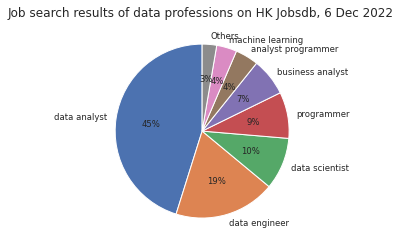

In [41]:
sns.color_palette("Set2")
ax = df_pie_title.plot(y='Count', 
                        kind='pie', 
                        labels= df_pie_title['Generic Title'], 
                        autopct = '%1.0f%%',
                        legend=False,
                        title='Job search results of data professions on HK Jobsdb, 6 Dec 2022 ',
                        startangle=90,
                        fontsize = 8.5, 
                      )   
ax.set(ylabel='')
ax.figure.savefig('job_titles.svg')
ax.figure.savefig('job_titles.png')


In [42]:
# convert no of years (strings) to no of years (int)

df_clean_3['years of experience'] = df_clean_3['years of experience'].str.extract('(\d+)')
df_clean_3.head()

,title,company,posted,district,career level,years of experience,qualification,job type,job functions,job_description,url,min_salary,max_salary,avg_salary
0,Data Scientist,Connexe Search Limited,2022-12-06,Kowloon Bay,NaN,NaN,NaN,Contract,"Banking / Finance, Others, Information Technol...",Our client is one of the leading financial ins...,https://hk.jobsdb.com/hk/en/job/data-scientist...,NaN,NaN,NaN
1,Data Analyst (Data & AI),NCSI (HK) Limited,2022-12-06,Tai Koo,NaN,NaN,NaN,"Full Time, Permanent","Information Technology (IT), Product Managemen...",Key Role Responsibilities:\n\nParticipate in c...,https://hk.jobsdb.com/hk/en/job/data-analyst-d...,NaN,NaN,NaN
2,Data Analyst (Data Governance),Gientech Technology (Hong Kong) Limited,2022-12-06,Ngau Tau Kok,Middle,3,Degree,"Full Time, Permanent","Information Technology (IT), Data Scientist",Duties:\nManage & support data governance mode...,https://hk.jobsdb.com/hk/en/job/data-analyst-d...,NaN,NaN,NaN
3,Solution Analyst - ICC - Data Integration,Cathay Pacific Airways Ltd,2022-12-06,Lantau Island,NaN,NaN,NaN,"Full Time, Permanent","Transportation & Logistics, Aviation Services,...",Reports to: Solution Lead / Senior Solution Le...,https://hk.jobsdb.com/hk/en/job/solution-analy...,NaN,NaN,NaN
4,Analyst Programmer (Data Analytics),China State Construction Engineering (Hong Kon...,2022-12-06,NaN,Entry Level,3,Degree,"Full Time, Permanent","Information Technology (IT), DBA, Others, Data...",Job Description:\nEstablish and maintain high-...,https://hk.jobsdb.com/hk/en/job/analyst-progra...,NaN,NaN,NaN


### Salary Statistics

note that only 6% of job ads had disclosed salary range

<AxesSubplot:xlabel='years of experience', ylabel='avg_salary'>

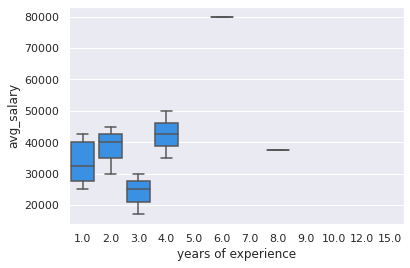

In [43]:
df_salary = df_clean_3.copy()
df_salary.sort_values(by=['years of experience'], inplace = True)
df_salary['years of experience'] = pd.to_numeric(df_salary['years of experience'], downcast = 'integer')
df_salary['avg_salary']
sns.boxplot( x=df_salary["years of experience"], y=df_salary["avg_salary"], color = 'dodgerblue' )

#### Why did yeo3 pay lower than yeo1,2?

By a look at the filtered data, one of the possible reason could be discrepancy in hiring companies. In some case, government contractor pays more than private companies. 


note: 
* lack of salary data
* when building regression model to predict salary, keep in mind that the company could be a significant feature.

In [44]:
df_salary[df_salary['years of experience']==3]

,title,company,posted,district,career level,years of experience,qualification,job type,job functions,job_description,url,min_salary,max_salary,avg_salary
336,Data Analyst - Bank,BDO Financial Services Limited,2022-11-08,NaN,Middle,3.0,Degree,"Full Time, Permanent","Banking / Finance, Financial Services, Profess...",Our client is a multinational bank with an all...,https://hk.jobsdb.com/hk/en/job/data-analyst-b...,NaN,NaN,NaN
194,Data Scientist,Dah Sing Financial Group,2022-11-21,NaN,Middle,3.0,Degree,"Full Time, Permanent","Banking / Finance, Retail Banking, Information...",Job Description:\nThe incumbent will support t...,https://hk.jobsdb.com/hk/en/job/data-scientist...,NaN,NaN,NaN
341,Data Analyst (Data Management) - Influential F...,Page Group Hong Kong,2022-11-08,NaN,Middle,3.0,Degree,"Full Time, Permanent","Information Technology (IT), DBA, Technical / ...",Our client is the most influential financial i...,https://hk.jobsdb.com/hk/en/job/data-analyst-d...,NaN,NaN,NaN
193,Data Analyst - Azure (Ref: GIT-DA),Dah Chong Hong Holdings Limited,2022-11-22,Kowloon Bay,Entry Level,3.0,Degree,"Full Time, Permanent","Professional Services, Business Analysis / Dat...",Responsibilities: \nResponsible for maintenanc...,https://hk.jobsdb.com/hk/en/job/data-analyst-a...,NaN,NaN,NaN
323,Cloud Data Engineer (Banking/ Insurance),PERSOLKELLY Hong Kong Limited,2022-11-09,Central & Western Area,Entry Level,3.0,Degree,Full Time,"Information Technology (IT), DBA, Software Dev...","Our client, cognitive solutions and cloud plat...",https://hk.jobsdb.com/hk/en/job/cloud-data-eng...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Senior Business Analyst - Supply Chain ERP App...,Maxim's Caterers Ltd,2022-11-28,Lai Chi Kok,Middle,3.0,Degree,"Full Time, Permanent","Information Technology (IT), Product Managemen...",Responsibilities:\nCollect and analyze data to...,https://hk.jobsdb.com/hk/en/job/senior-busines...,NaN,NaN,NaN
141,Data Engineer (Cloud Platform - Up to 40K+),ADECCO,2022-11-28,Central,Middle,3.0,Degree,"Full Time, Contract","Information Technology (IT), Application Speci...",Our client is a Hong Kong's central banking in...,https://hk.jobsdb.com/hk/en/job/data-engineer-...,NaN,NaN,NaN
116,Senior / Data Analyst (Data Scientist),Bank of China (Hong Kong) Limited,2022-11-30,Shatin Area,Middle,3.0,Degree,Full Time,"Information Technology (IT), Data Scientist",Responsibilities:\nCollaborate with business u...,https://hk.jobsdb.com/hk/en/job/senior-data-an...,NaN,NaN,NaN
127,"Assistant Manager, Digital Experience - Property",Robert Walters (HK),2022-11-30,NaN,Senior,3.0,Degree,"Full Time, Permanent","Information Technology (IT), Mobile / Wireless...",One of the leading property developers is look...,https://hk.jobsdb.com/hk/en/job/assistant-mana...,NaN,NaN,NaN


In [45]:
df_salary[df_salary['years of experience']<=2]

,title,company,posted,district,career level,years of experience,qualification,job type,job functions,job_description,url,min_salary,max_salary,avg_salary
74,Data Analyst,DataTech Global (HK) Limited,2022-12-01,Kwun Tong,NaN,1.0,Degree,"Full Time, Permanent","Professional Services, Business Analysis / Dat...",Responsibilities: \nCoordinate with clients to...,https://hk.jobsdb.com/hk/en/job/data-analyst-1...,NaN,NaN,NaN
219,IT TRAINEE,Ma Belle Jewellery Co Ltd,2022-11-21,Tin Hau,Entry Level,1.0,Degree,"Full Time, Internship","Information Technology (IT), Application Speci...",INTERNSHIP\n\nSupport the Head of Application ...,https://hk.jobsdb.com/hk/en/job/it-trainee-100...,NaN,NaN,NaN
302,"Data Analyst, Insurance, 18k - 24k (WELCOME FR...",Ambition,2022-11-09,Central & Western Area,Entry Level,1.0,Degree,"Full Time, Contract","Information Technology (IT), Product Managemen...",Job Duties\nProvide data analysis and insights...,https://hk.jobsdb.com/hk/en/job/data-analyst-i...,NaN,NaN,NaN
60,Data QA Analyst,Viu,2022-12-02,Kowloon Bay,Entry Level,1.0,NaN,"Full Time, Contract","Information Technology (IT), Application Speci...",Key responsibilities\nDesign & execute test pl...,https://hk.jobsdb.com/hk/en/job/data-qa-analys...,NaN,NaN,NaN
250,Analyst Programmer / Programmer / Software Dev...,PMAX Consultant Limited,2022-11-16,Kwun Tong Area,Middle,1.0,Non-Degree Tertiary,Full Time,"Information Technology (IT), Application Speci...",Analyst Programmer / Programmer / Software Dev...,https://hk.jobsdb.com/hk/en/job/analyst-progra...,30000.0,55000.0,42500.0
34,Business Development Officer,Phillip Securities Group,2022-12-05,Admiralty,NaN,1.0,Degree,"Full Time, Permanent","Banking / Finance, Others, Sales, CS & Busines...",Responsibilities:\nAssist in managing all asp...,https://hk.jobsdb.com/hk/en/job/business-devel...,NaN,NaN,NaN
261,Platform Operation Executive,Anymind Hong Kong Limited,2022-11-15,Kwun Tong,Entry Level,1.0,Non-Degree Tertiary,"Full Time, Permanent","Information Technology (IT), Product Managemen...",What You'll Do\nFocus on maximizing app publis...,https://hk.jobsdb.com/hk/en/job/platform-opera...,NaN,NaN,NaN
121,(Senior) Analyst / Engineer – Datawarehouse an...,Acton Consulting Limited,2022-11-30,NaN,Middle,1.0,Non-Degree Tertiary,"Full Time, Permanent","Information Technology (IT), DBA, Network & Sy...",Responsibilities:\nGather and interpret busine...,https://hk.jobsdb.com/hk/en/job/senior-analyst...,NaN,NaN,NaN
122,Junior Database Administrator (Banking Clients...,Links International,2022-11-30,Kwun Tong Area,Middle,1.0,Degree,"Full Time, Permanent","Information Technology (IT), DBA, Support, Dat...",Our client is a leading IT service and consult...,https://hk.jobsdb.com/hk/en/job/junior-databas...,30000.0,35000.0,32500.0
125,"CRM Specialist, Property - Welcome Agency Back...",Robert Walters (HK),2022-11-30,NaN,Middle,1.0,Degree,"Full Time, Permanent","Information Technology (IT), Product Managemen...",One of the leading property developers is look...,https://hk.jobsdb.com/hk/en/job/crm-specialist...,NaN,NaN,NaN


### How does years of experience affect salary?
not neccessarily yes

note: lack of salary data, high variance

[Text(0.5, 1.0, 'Does 2 yeo pay more than yeo 1?'), Text(0.5, 0, 'yeo<2')]

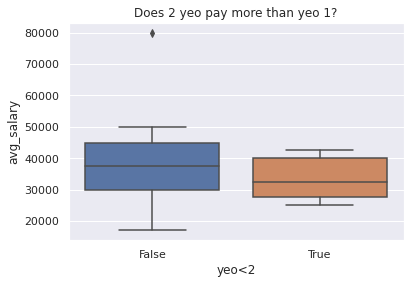

In [46]:
sns.boxplot( x=df_salary["years of experience"]<2, y=df_salary["avg_salary"]).set(title = 'Does 2 yeo pay more than yeo 1?', xlabel = 'yeo<2' )

In [47]:
df_salary.dropna(subset = ['avg_salary'], inplace=True)
yeo_1 = df_salary[df_salary["years of experience"]==1]['avg_salary']
yeo_2 = df_salary[df_salary["years of experience"]==2]['avg_salary']
yeo_4 = df_salary[df_salary["years of experience"]==4]['avg_salary']
f_oneway(yeo_1, yeo_2)

F_onewayResult(statistic=0.7526849642004771, pvalue=0.41896861093759263)

In [48]:
f_oneway(yeo_1, yeo_2, yeo_4)

F_onewayResult(statistic=0.9587093862815886, pvalue=0.42855451277745826)

* important note: lack of salary data
failed to reject null hypothesis in one anova
from this limited data, there is no difference 

### Career level, yeo, qualification

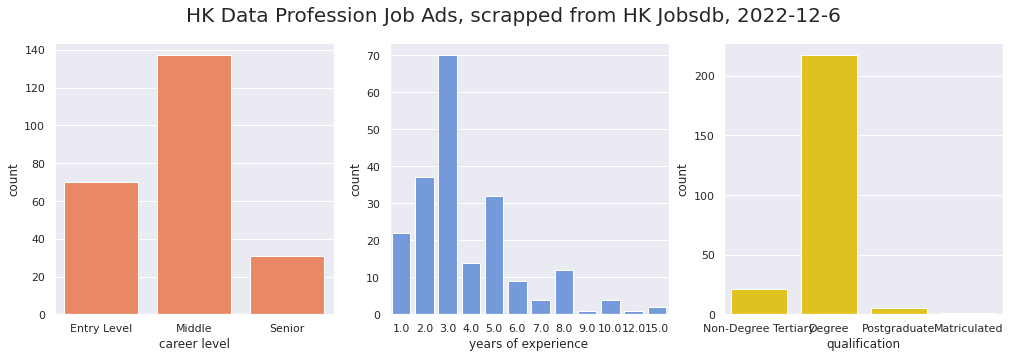

In [49]:
# career level, years of experience, qualification breakdown
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
df_p1 = df_clean_3.copy()

fig.suptitle('HK Data Profession Job Ads, scrapped from HK Jobsdb, 2022-12-6',size=20)

career_level_order = ['Entry Level', 'Middle', 'Senior']
plot_career_level = sns.countplot(x='career level',data=df_p1, ax = axes[0], order = career_level_order, color='coral')

df_p1['years of experience'] = pd.to_numeric(df_p1['years of experience'], downcast = 'integer')
df_p1.sort_values(by=['years of experience'],inplace=True)
plot_yoe = sns.countplot(x='years of experience',data=df_p1, ax = axes[1], color = 'cornflowerblue')

plot_quali = sns.countplot(x='qualification',data=df_p1, ax = axes[2], color = 'gold')

fig.savefig('additional_info_breakdown.svg')
fig.figure.savefig('additional_info_breakdown.png')


### Mapping job locations

In [50]:
geolocator = Nominatim(user_agent="Your_Name")

In [51]:
df_map = df_raw.copy()

In [52]:
to_drop = ['Overseas',
           'Others',
           'Southern Area']

for i in to_drop:
    df_map['district'].replace(i,np.nan,inplace = True)
    
df_map['district'].replace('Aberdeen','Aberdeen, Hong Kong',inplace = True)
df_map['district'].replace('Airport Area','Hong Kong airport, Hong Kong',inplace = True)
df_map['district'].replace('Tai Po Area','Tai Po',inplace = True)
 

In [53]:
df_map['district'].replace('district', np.nan)

0        Kowloon Bay
1            Tai Koo
2       Ngau Tau Kok
3      Lantau Island
4                NaN
           ...      
344              NaN
345         Wan Chai
346         Wan Chai
347    Tseung Kwan O
348    Lantau Island
Name: district, Length: 349, dtype: object

In [54]:
def my_geocoder(row):
    '''
    returns lattitude and longtitude from a column of place names
    '''
    try:
        point = geolocator.geocode(row).point
        return pd.Series({'Latitude': point.latitude, 'Longitude': point.longitude})
    except:
        return None

df_map[['Latitude', 'Longitude']] = df_map.apply(lambda x: my_geocoder(x['district']), axis=1)

print("{}% of addresses were geocoded!".format(
    (1 - sum(np.isnan(df_map["Latitude"])) / len(df_map)) * 100))


100.0% of addresses were geocoded!


In [55]:
df_map_2 = gpd.GeoDataFrame(
    df_map, geometry=gpd.points_from_xy(df_map.Longitude, df_map.Latitude))
df_map_2.crs = {'init': 'epsg:4326'}


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [56]:
df_map_2.to_csv('geo_data.csv', index = False)

In [57]:
df_map_3 = df_map_2[df_map_2['district'].notna()]
df_map_3 = df_map_3[df_map_3['Latitude'].notna()]
df_map_3 = df_map_3[df_map_3['Longitude'].notna()]
df_map_3 = df_map_3[df_map_3['geometry'].notna()]

#### the map

In [58]:
# Create a map
m = folium.Map(location=[22.34, 114.1], tiles='openstreetmap', zoom_start=11, control_scale=True)

# Add points to the map
for idx, row in df_map_3.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['district']).add_to(m)

# Display the map
m

In [59]:
m.save('hk_data_job_geodistribution.html')

# Limitations 

* Limitation of this study remains on the lack of salary data. One of the solution could be pooling data from other job posting platforms. 

# What could be possible next?
* unsupervised ML:  standardize job titles into categorical variable to do kmeans clustering
* compare this study with data science related job postings in other countries